# Non-linear Gaussian filtering and smoothing (discrete)

Provided is an example of a nonlinear state-space model on which one can perform Bayesian filtering and smoothing in order to obtain
a posterior distribution over a latent state trajectory based on noisy observations.
In order to understand the theory behind these methods in detail we refer to [1] and [2].

In order to perform Bayesian Filtering and Smoothing on non-linear models, we show how to use functionalities provided by ProbNum to
either linearise the respective model (Extended Kalman Filter, EKF) or to use an Unscented Transform (Unscented Kalman Filter, UKF) which does not require a Jacobian of the nonlinear model.

**References**:
> [1] Särkkä, Simo, and Solin, Arno. Applied Stochastic Differential Equations. Cambridge University Press, 2019.  
>
> [2] Särkkä, Simo. Bayesian Filtering and Smoothing. Cambridge University Press, 2013.

In [1]:
import numpy as np

import probnum as pn
from probnum import filtsmooth, randvars, randprocs
from probnum.problems import TimeSeriesRegressionProblem

In [2]:
rng = np.random.default_rng(seed=123)

In [3]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.style.use("../../probnum.mplstyle")

/tmp/ipykernel_17168/236124620.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "svg")


## **Non-Linear Discrete** State-Space Model: Pendulum

---

For nonlinear models, we assume that at least one of the components of our state-space model (i.e. either the dynamics, the measurement model, or both) is a nonlinear function of the latent state.

Consider nonlinear functions $f: \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $h: \mathbb{R}^d \rightarrow \mathbb{R}^m$ where $d$ is the dimension of the latent state and
$m$ is the dimension of the measurements.

For $k = 1, \dots, K$ and $x_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$:

$$
\begin{align}
    \boldsymbol{x}_k &\sim \mathcal{N}(f(\boldsymbol{x}_{k-1}), \boldsymbol{Q}) \\
    \boldsymbol{y}_k &\sim \mathcal{N}(h(\boldsymbol{x}_k), \boldsymbol{R})
\end{align}
$$

This defines a dynamics model that assumes a state $x_k$ in a **discrete** sequence of states arising from a nonlinear map of the previous state $x_{k-1}$ corrupted with additive Gaussian noise under a **process noise** covariance matrix $Q$.  
Similarly, the measurements $y_k$ are assumed to be nonlinear transformations of the latent state under additive Gaussian noise according to a **measurement noise** covariance $R$.
In the described case, we cannot use the Kalman Filtering equations since these assume linear relationships. One method is to linearise the nonlinear parts of the model by a first-order Taylor Expansion (Extended Kalman Filter, EKF) or employing the Unscented Kalman Filter (UKF) which is based on the unscented transform and does not require the computation of a Jacobian.
The `probnum` packages provides both methods by wrapping linearizing "Components" around nonlinear dynamcis and/or measurement models, as we will see below.

Note that this can be generalized to a nonlinear time-varying state-space model, as well. Then we would have $f: \mathbb{T} \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ and $h: \mathbb{T} \times \mathbb{R}^d \rightarrow \mathbb{R}^m$ where $\mathbb{T}$ is the "time dimension".

### Define State-Space Model

#### I. Discrete Dynamics Model: Nonlinear Gaussian Transitions

In [4]:
state_dim = 2
observation_dim = 1

In [5]:
# approx. gravitational constant
g = 9.81
# dt
delta_t = 0.0075


def pendulum_rhs(state):
    """Right-hand side of an ODE that defines pendulum dynamics"""
    x1, x2 = state
    y1 = x1 + x2 * delta_t
    y2 = x2 - g * np.sin(x1) * delta_t
    return np.array([y1, y2])


def pendulum_jacobian(state):
    """Jacobian of the pendulum ODE"""
    x1, x2 = state
    dy1_dx = [1.0, delta_t]
    dy2_dx = [-g * np.cos(x1) * delta_t, 1.0]
    return np.array([dy1_dx, dy2_dx])


dynamics_transition_function = lambda t, state: pendulum_rhs(state)
dynamics_transition_jacobian_function = lambda t, state: pendulum_jacobian(state)

dynamics_diffusion_matrix = 1.0 * (
    np.diag(np.array([delta_t ** 3 / 3, delta_t]))
    + np.diag(np.array([delta_t ** 2 / 2]), 1)
    + np.diag(np.array([delta_t ** 2 / 2]), -1)
)

We here define the non-linear dynamics of a pendulum.

In [6]:
noise = randvars.Normal(
    mean=np.zeros(dynamics_diffusion_matrix.shape[0]), cov=dynamics_diffusion_matrix
)


# Create discrete, non-linear Gaussian dynamics model
dynamics_model = randprocs.markov.discrete.NonlinearGaussian(
    input_dim=state_dim,
    output_dim=state_dim,
    transition_fun=dynamics_transition_function,
    noise_fun=lambda t: noise,
    transition_fun_jacobian=dynamics_transition_jacobian_function,
)

#### II. Discrete Measurement Model: Nonlinear Gaussian Measurements

In [7]:
def pendulum_measurement(state):
    x1, x2 = state
    return np.array([np.sin(x1)])


def pendulum_measurement_jacobian(state):
    x1, x2 = state
    return np.array([[np.cos(x1), 0.0]])


measurement_function = lambda t, state: pendulum_measurement(state)
measurement_jacobian_function = lambda t, state: pendulum_measurement_jacobian(state)

measurement_variance = 0.32 ** 2
measurement_covariance = measurement_variance * np.eye(observation_dim)

In [8]:
measurement_jacobian_function(0, np.ones(2)) @ np.ones(2)

array([0.54030231])

In [9]:
# Create discrete, non-linear Gaussian measurement model
measurement_noise = randvars.Normal(mean=np.zeros(measurement_covariance.shape[0]), cov=measurement_covariance)
measurement_model = randprocs.markov.discrete.NonlinearGaussian(
    input_dim=state_dim,
    output_dim=observation_dim,
    transition_fun=measurement_function,
    noise_fun=lambda t: measurement_noise,
    transition_fun_jacobian=measurement_jacobian_function,
)


#### III. Initial State Random Variable

In [10]:
mu_0 = np.ones(state_dim)
sigma_0 = measurement_variance * np.eye(state_dim)
initial_state_rv = randvars.Normal(mean=mu_0, cov=sigma_0)

### Kalman Filtering

#### I. Linearize model (Extended Kalman Filter)

Since we could easily derive the Jacobian of our nonlinear model components above, we can use the Extended Kalman Filter (EKF) to obtain a filtering posterior over the states. Therefore, in `probnum` we just wrap the dynamics model and the measurement model in a `DiscreteEKFComponent` object.
In cases in which the Jacobian is not as easy to write down, `probnum` also provides the `DiscreteUKFComponent` class that implements the linearization by means of an
_unscented Kalman filter_ that does not require a Jacobian.
Alternatively, the Jacobian can be calculated via automatic differentiation.

In [11]:
linearised_dynamics_model = filtsmooth.gaussian.approx.DiscreteEKFComponent(
    dynamics_model
)


In [12]:
prior_process = randprocs.markov.MarkovSequence(
    transition=linearised_dynamics_model, initrv=initial_state_rv, initarg=0.0
)

#### II. Kalman Filter

Then, we simply pass these linearized models to the Kalman Filter (exactly the same interface as in the linear case) and proceed.

In [13]:
kalman_filter = filtsmooth.gaussian.Kalman(prior_process)

#### III. Generate Data for the State-Space Model

`statespace.generate_artificial_measurements()` is used to sample both latent states and noisy observations from the specified state space model.

In [14]:
time_grid = np.arange(0.0, 5.0, step=delta_t)

In [15]:
latent_states, observations = randprocs.markov.utils.generate_artificial_measurements(
    rng=rng,
    prior_process=prior_process,
    measmod=measurement_model,
    times=time_grid,
)
regression_problem = TimeSeriesRegressionProblem(
    observations=observations,
    locations=time_grid,
    measurement_models=[
        filtsmooth.gaussian.approx.DiscreteEKFComponent(measurement_model)
    ]
    * len(time_grid),
)

#### IV. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [16]:
state_posterior, _ = kalman_filter.filtsmooth(regression_problem)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and interpolation.
We can also extract the just computed posterior smoothing state variables.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [17]:
posterior_state_rvs = (
    state_posterior.states
)  # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean  # Shape: (num_time_points, state_dim)
posterior_state_covs = (
    posterior_state_rvs.cov
)  # Shape: (num_time_points, state_dim, state_dim)

### Visualize Results

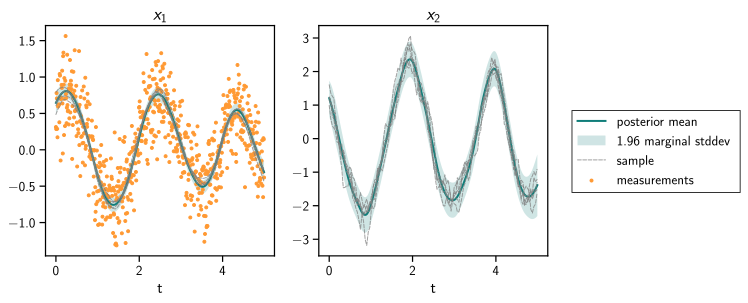

In [18]:
state_fig = plt.figure()
state_fig_gs = gridspec.GridSpec(ncols=2, nrows=1, figure=state_fig)

ax_00 = state_fig.add_subplot(state_fig_gs[0, 0])
ax_01 = state_fig.add_subplot(state_fig_gs[0, 1])

# Plot means
mu_x_1, mu_x_2 = [posterior_state_means[:, i] for i in range(state_dim)]

ax_00.plot(time_grid, mu_x_1, label="posterior mean")
ax_01.plot(time_grid, mu_x_2)

# Plot marginal standard deviations
std_x_1, std_x_2 = [np.sqrt(posterior_state_covs[:, i, i]) for i in range(state_dim)]

ax_00.fill_between(
    time_grid,
    mu_x_1 - 1.96 * std_x_1,
    mu_x_1 + 1.96 * std_x_1,
    alpha=0.2,
    label="1.96 marginal stddev",
)
ax_01.fill_between(
    time_grid, mu_x_2 - 1.96 * std_x_2, mu_x_2 + 1.96 * std_x_2, alpha=0.2
)

# Plot 5 samples on a subsampled grid
samples = state_posterior.sample(rng=rng, t=state_posterior.locations[::5], size=5)
for smp in samples:
    ax_00.plot(
        state_posterior.locations[::5],
        smp[:, 0],
        color="gray",
        alpha=0.75,
        linewidth=1,
        linestyle="dashed",
        label="sample",
    )
    ax_01.plot(
        state_posterior.locations[::5],
        smp[:, 1],
        color="gray",
        alpha=0.75,
        linewidth=1,
        linestyle="dashed",
        label="sample",
    )


# Plot groundtruth
ax_00.scatter(time_grid, observations, marker=".", label="measurements")


# Add labels etc.
ax_00.set_xlabel("t")
ax_01.set_xlabel("t")

ax_00.set_title(r"$x_1$")
ax_01.set_title(r"$x_2$")

# The following two lines are just to remove duplicate labels (caused by samples) from the legend
handles, labels = ax_00.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

state_fig.legend(
    by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
)

state_fig.tight_layout()